# Dogs vs Cat Redux

In [1]:
%matplotlib inline

In [2]:
import os, sys
from __future__ import division, print_function

import json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.layers import Input, Flatten, Dense

# In case we are going to use the TensorFlow backend we need to explicitly set the Theano image ordering
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
DATA_HOME_DIR = '/home/ubuntu/data/dogscats'

# Data preparation

In [132]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/data/dogscats


In [134]:
# Create validation set by moving some files to /valid
%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

/home/ubuntu/data/dogscats/train


In [137]:
# Create sample train set by Copying a subset
from shutil import copyfile

%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(400): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])
    
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

/home/ubuntu/data/dogscats/train
/home/ubuntu/data/dogscats/valid


In [138]:
# Rearrange image files into their respective directories
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/data/dogscats/sample/train
/home/ubuntu/data/dogscats/sample/valid
/home/ubuntu/data/dogscats/valid
/home/ubuntu/data/dogscats/train


In [139]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/data/dogscats/test


# Init

In [4]:
DATA_HOME_DIR = '/home/ubuntu/data/dogscats'
#Set path to sample/ path if desired
# path = DATA_HOME_DIR + '/' 
path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

In [5]:
# Set constants
batch_size=64
no_of_epochs=3

# Data attributes
CHANNELS = 3
ROWS = 224
COLS = 224

In [6]:
#https://keras.io/applications/
from keras.applications.vgg16 import VGG16

In [7]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


In [8]:
#Get back the convolutional part of a VGG network trained on ImageNet
#     include_top: whether to include the 3 fully-connected layers at the top of the network.
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
# model_vgg16_conv = VGG16(weights='imagenet', include_top=False,
#                         input_tensor=None, input_shape=(3,224,224), pooling=None)
model_vgg16_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, None, None)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, None, None)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, None, None)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, None, None)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, None, None)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, None, None)   0         
__________

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/applications/vgg16.py:184: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


In [9]:
#Create your own input format
input = Input(shape=(CHANNELS,ROWS,COLS), name = 'image_input')

#Use the generated model 
base_model = model_vgg16_conv(input)

In [10]:
#Add the fully-connected layers 
x = Flatten(name='flatten')(base_model)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.4)(x)
x = Dense(2, activation='softmax', name='predictions')(x)

#Create your own model 
model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 3, 224, 224)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
__________

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 3, 224, 224)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4096)              0         
__________

In [13]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7fbb70d38828> False
<keras.engine.training.Model object at 0x7fbb70e00da0> True
<keras.layers.core.Flatten object at 0x7fbb70062518> True
<keras.layers.core.Dense object at 0x7fbb70062550> True
<keras.layers.core.Dropout object at 0x7fbb70062630> True
<keras.layers.core.Dense object at 0x7fbb70062f28> True
<keras.layers.core.Dropout object at 0x7fbb700625c0> True
<keras.layers.core.Dense object at 0x7fbb3d606fd0> True


In [14]:
# metrics
## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.epoch_count=0
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        
    def on_epoch_end(self, batch, logs={}):
        self.epoch_count += 1
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('acc'))
        self.val_accuracies.append(logs.get('val_acc'))


In [15]:
history = LossHistory()

## Training

In [16]:
# def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
#         """
#             Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

#             See Keras documentation: https://keras.io/preprocessing/image/
#         """
#         return gen.flow_from_directory(path, target_size=(224,224),
#                 class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [17]:
# prepare data augmentation configuration
train_datagen = image.ImageDataGenerator(preprocessing_function=vgg_preprocess,
                                    shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True)

val_datagen = image.ImageDataGenerator(preprocessing_function=vgg_preprocess)


In [18]:
# These objects are keras.preprocessing.image.DirectoryIterator
train_batches = train_datagen.flow_from_directory(train_path, 
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  shuffle=True, 
                                                  batch_size=batch_size)

val_batches = val_datagen.flow_from_directory(train_path, 
                                                  target_size=(224,224), 
                                                  class_mode='categorical', 
                                                  shuffle=False, 
                                                  batch_size=batch_size)

Found 795 images belonging to 2 classes.
Found 795 images belonging to 2 classes.


In [19]:
#  This warning occurs if there's any Keras 1.0 keyword in your function call. 
# Update your function call by replacing nb_epoch with epochs, and nb_val_samples with validation_steps.


In [20]:
# train the model on the new data for a few epochs
def train(epochs, lr):
    nb_epoch=epochs
#     model.optimizer.lr = lr
    model.fit_generator(train_batches, steps_per_epoch=train_batches.samples/batch_size, epochs=epochs,
                    validation_data=val_batches, validation_steps=val_batches.samples/batch_size, 
                    callbacks=[history])

In [21]:
train_batches.samples

795

In [22]:
train(1, 0.01)

Epoch 1/1
13/12 [===============================] - 29s 2s/step - loss: 4.5296 - acc: 0.5770 - val_loss: 1.5400 - val_acc: 0.7711


In [25]:
train(5, 0.001)

Epoch 1/5
13/12 [===============================] - 20s 2s/step - loss: 1.7094 - acc: 0.8081 - val_loss: 0.5737 - val_acc: 0.9220
Epoch 2/5
13/12 [===============================] - 19s 1s/step - loss: 1.4226 - acc: 0.8546 - val_loss: 0.4635 - val_acc: 0.9296
Epoch 3/5
13/12 [===============================] - 19s 1s/step - loss: 1.3537 - acc: 0.8567 - val_loss: 0.4557 - val_acc: 0.9396
Epoch 4/5
13/12 [===============================] - 19s 1s/step - loss: 1.0510 - acc: 0.8751 - val_loss: 0.3377 - val_acc: 0.9472
Epoch 5/5
13/12 [===============================] - 19s 1s/step - loss: 1.0983 - acc: 0.8824 - val_loss: 0.3976 - val_acc: 0.9484


In [27]:
train(5, 0.0001)

Epoch 1/5
13/12 [===============================] - 20s 2s/step - loss: 0.7943 - acc: 0.9189 - val_loss: 0.2395 - val_acc: 0.9635
Epoch 2/5
13/12 [===============================] - 19s 1s/step - loss: 0.7454 - acc: 0.9122 - val_loss: 0.2164 - val_acc: 0.9635
Epoch 3/5
13/12 [===============================] - 19s 1s/step - loss: 0.7848 - acc: 0.9065 - val_loss: 0.1533 - val_acc: 0.9799
Epoch 4/5
13/12 [===============================] - 20s 2s/step - loss: 0.6614 - acc: 0.9201 - val_loss: 0.1077 - val_acc: 0.9849
Epoch 5/5
13/12 [===============================] - 19s 1s/step - loss: 0.6193 - acc: 0.9346 - val_loss: 0.0901 - val_acc: 0.9849


In [28]:
train(5, 0.00001)

Epoch 1/5
13/12 [===============================] - 20s 2s/step - loss: 0.5782 - acc: 0.9321 - val_loss: 0.0878 - val_acc: 0.9874
Epoch 2/5
13/12 [===============================] - 19s 1s/step - loss: 0.5124 - acc: 0.9442 - val_loss: 0.0620 - val_acc: 0.9912
Epoch 3/5
13/12 [===============================] - 19s 1s/step - loss: 0.5801 - acc: 0.9285 - val_loss: 0.1042 - val_acc: 0.9874
Epoch 4/5
13/12 [===============================] - 19s 1s/step - loss: 0.4587 - acc: 0.9433 - val_loss: 0.0636 - val_acc: 0.9925
Epoch 5/5
13/12 [===============================] - 19s 1s/step - loss: 0.3940 - acc: 0.9469 - val_loss: 0.0877 - val_acc: 0.9925


In [78]:
history.epoch_count

1

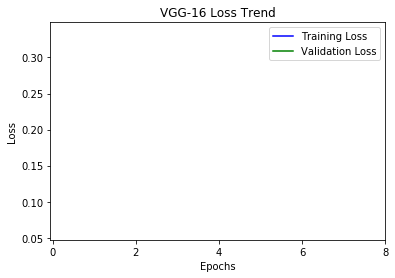

In [79]:
import matplotlib.pyplot as plt
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,10)[0::2])
plt.legend()
plt.show()

In [133]:
# Save model weights
model.save_weights(results_path + '/model_weights')

In [14]:
# Load from weights
vgg.model.load_weights(results_path + '/model_weights')

## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [30]:
def get_batches(path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [33]:
print(test_path)

/home/ubuntu/data/dogscats/test/


In [34]:
test_batches = get_batches(test_path, shuffle=False, batch_size=batch_size*2, class_mode=None)

Found 12500 images belonging to 1 classes.


In [36]:
preds = model.predict_generator(test_batches, test_batches.samples)

In [37]:
preds[:5]

array([[  7.73966452e-03,   9.92260396e-01],
       [  1.00000000e+00,   3.20579932e-25],
       [  1.00000000e+00,   6.89448434e-29],
       [  6.15536165e-19,   1.00000000e+00],
       [  1.05926999e-13,   1.00000000e+00]], dtype=float32)

In [38]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = test_batches.filenames
print(filenames[:5])

[[  7.73966452e-03   9.92260396e-01]
 [  1.00000000e+00   3.20579932e-25]
 [  1.00000000e+00   6.89448434e-29]
 [  6.15536165e-19   1.00000000e+00]
 [  1.05926999e-13   1.00000000e+00]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg', 'unknown/10000.jpg']


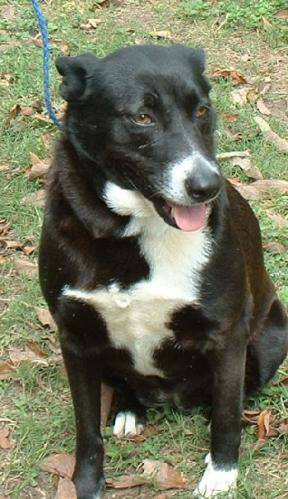

In [41]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(DATA_HOME_DIR + '/test/' + filenames[3])

In [45]:
import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [46]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [61]:
model.load_weights(results_path+latest_weights_filename)

NameError: name 'vgg' is not defined

In [47]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

NameError: name 'vgg' is not defined

In [30]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [31]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1964 correct labels


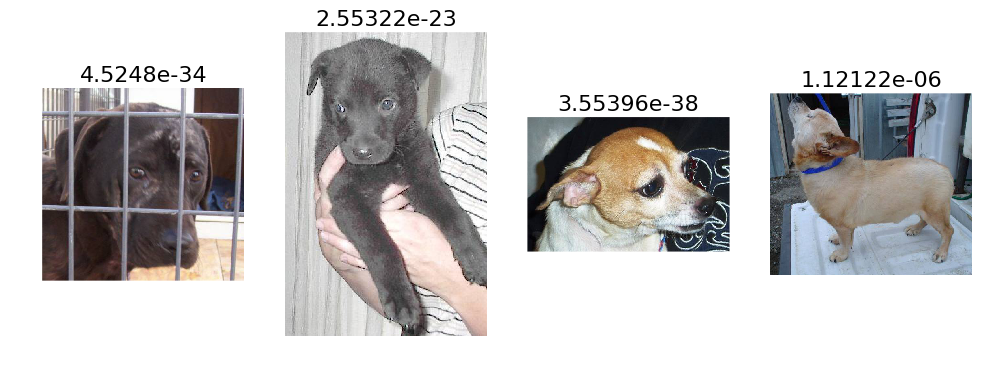

In [32]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 36 incorrect labels


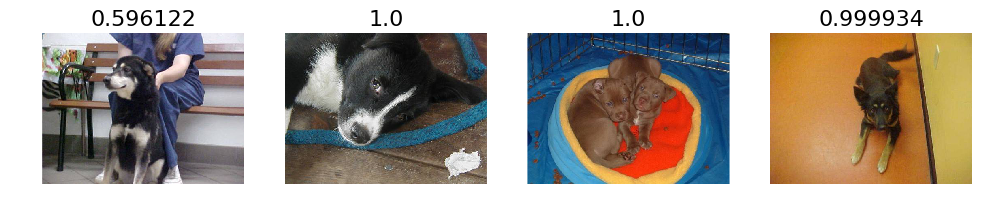

In [33]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 986 confident correct cats labels


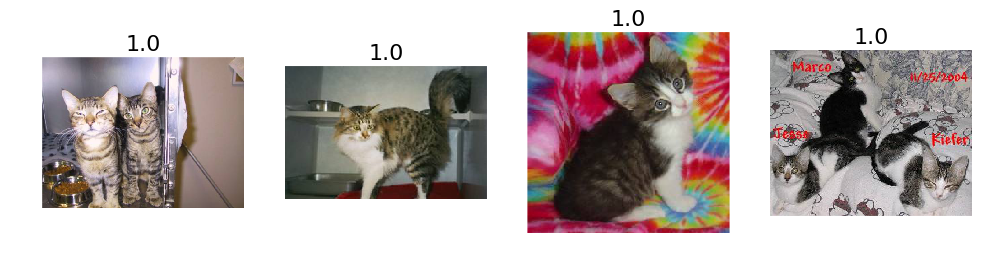

In [34]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 978 confident correct dogs labels


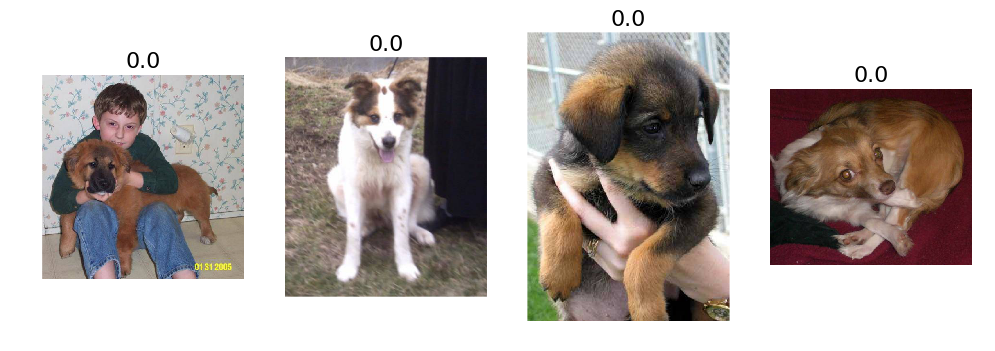

In [35]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 22 incorrect cats


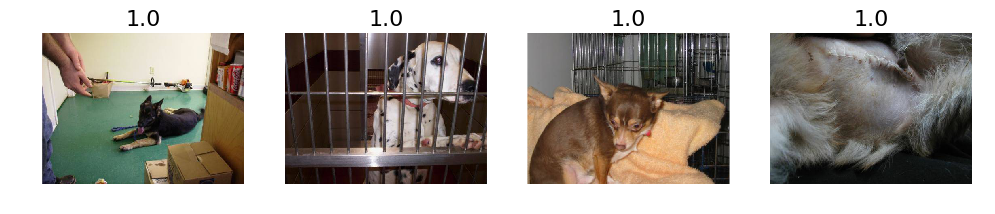

In [36]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 14 incorrect dogs


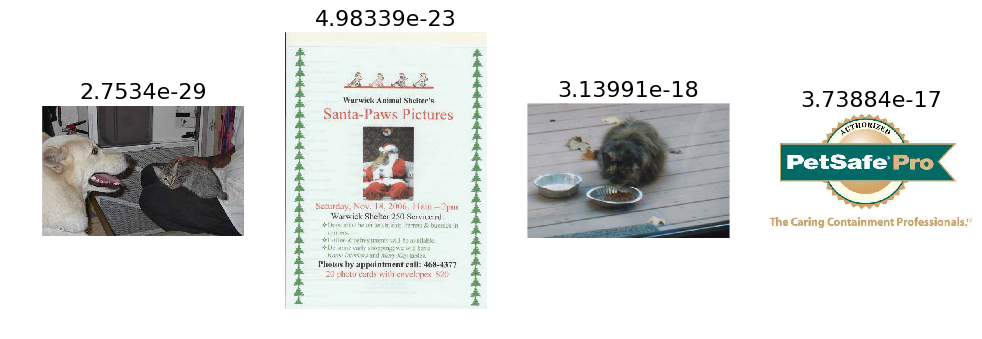

In [37]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

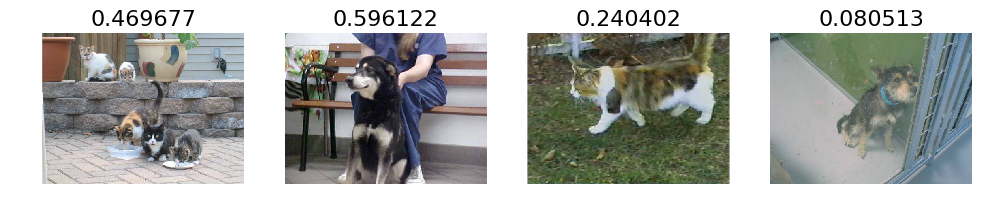

In [38]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[986  14]
 [ 22 978]]


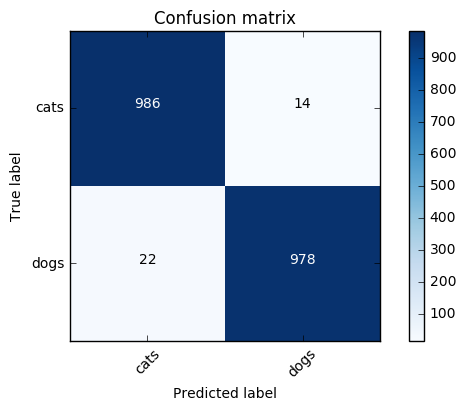

In [40]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [48]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [49]:
isdog = preds[:,1]

In [50]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]) )
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]) )
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]) )

Raw Predictions: [  9.92260396e-01   3.20579932e-25   6.89448434e-29   1.00000000e+00
   1.00000000e+00]
Mid Predictions: [ 0.57532752  0.5798462   0.45577857  0.40124735  0.57248366  0.55484784
  0.49810365  0.52388376  0.48577642  0.53853726  0.51794446  0.59779555
  0.57337379  0.42864308  0.42903453  0.54163104  0.57341999  0.48151076
  0.54689777  0.47951594  0.52144164  0.41335523  0.44716603  0.44426951
  0.56984574  0.52495652  0.52455616  0.55336177  0.46237063  0.52838725
  0.44899055  0.55579174  0.56364489  0.56550521  0.47493953  0.42062587
  0.43701294  0.58770639  0.51115352  0.40626392  0.47233152  0.44204408
  0.44191524  0.47165135  0.45859671  0.56188494  0.45667487  0.57465601
  0.40268591  0.58810246  0.5469225   0.57532883  0.56592882  0.44905707
  0.51013207  0.50288111  0.47672215  0.52318984  0.42985821  0.4441306
  0.47485638  0.57825547  0.40194413  0.4314369   0.42821601  0.59367484
  0.46034348  0.57959843  0.50868022  0.54167426  0.46190068  0.57910299
  0

[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

In [51]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

ValueError: y_true contains only one label (1). Please provide the true labels explicitly through the labels argument.

In [52]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [53]:
filenames = test_batches.filenames
print(filenames[:5])

['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg', 'unknown/10000.jpg']


In [54]:
filenameparser = lambda filename: int( filename[5:filename.find('.')] )
# debug
print(filenameparser('test/9292.jpg'))
print(filenameparser('test/92.jpg'))

9292
92


In [55]:
filenameparser_vec = np.vectorize(filenameparser)

In [56]:
ids = filenameparser_vec(filenames)

ValueError: invalid literal for int() with base 10: 'wn/1'

Here we join the two columns into an array of [imageId, isDog]

In [57]:
ids.shape

NameError: name 'ids' is not defined

In [74]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.29200000e+03,   5.00000007e-02],
       [  1.20260000e+04,   9.49999988e-01],
       [  9.68800000e+03,   1.34595707e-01],
       [  4.39200000e+03,   5.00000007e-02],
       [  7.79000000e+02,   9.49999988e-01]])

In [75]:
submission_file_name = DATA_HOME_DIR + '/submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')
print("saved to " + submission_file_name)

saved to /home/ubuntu/data/dogscats/submission1.csv


In [76]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/ubuntu/data/dogscats/submission1.csv

You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.